- pca로 축소

- cat, rgbm, xgb
- 앙상블 : 모델 좀 필요함 \ 제일 잘 나온 모델만 튜닝 -> 이상함
- 각자가 진행 ipynb, .txt 공유
- 나중엔 제출일 가까워졌을 땐, 최적의 점수가 나오는 모델을 다같이 튜닝

## **라이브러리**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

## **데이터 준비**

### **Data Dictionary**
|변수|정의|설명|데이터 유형|
|:-:|:-:|:-:|:-:|
|PRODUCT_ID|제품의 고유 ID||명목형 변수|
|Y_Class|제품 품질 상태 **(Target)**|0 : 적정 기준 미달 (부적합)<br>1 : 적합<br>2 : 적정 기준 초과 (부적합)|순서형 변수|
|Y_Quality|제품 품질 관련 정량적 수치 ||연속형 변수|
|TIMESTAMP|제품이 공정에 들어간 시각||연속형 변수|
|LINE|제품이 들어간 공정 LINE 종류|'T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305'<br><br>train과 test 모두 동일한 종류가 존재함|명목형 변수|
|PRODUCT_CODE|제품의 CODE 번호|'A_31', 'T_31', 'O_31'<br><br>train과 test 모두 동일한 종류가 존재함|명목형 변수|
|X_1 ~ X_2875|공정 과정에서 추출되어 비식별화된 변수|보안상의 이유로, 일부 변수가 비식별화 처리됨|연속형 변수|

### **데이터 불러오기**

In [3]:
train_df = pd.read_csv('C:\\VSC\\LGAimers_Hackathon\\dataset\\train.csv')
test_df = pd.read_csv('C:\\VSC\\LGAimers_Hackathon\\dataset\\test.csv')

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_rows', 10)

## **EDA**

### **데이터 탐색/전처리/시각화**

In [4]:
train_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [6]:
test_df.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_df[["PRODUCT_ID", "Y_Class", "Y_Quality", "TIMESTAMP", "LINE", "PRODUCT_CODE"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PRODUCT_ID    598 non-null    object 
 1   Y_Class       598 non-null    int64  
 2   Y_Quality     598 non-null    float64
 3   TIMESTAMP     598 non-null    object 
 4   LINE          598 non-null    object 
 5   PRODUCT_CODE  598 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 28.2+ KB


In [8]:
test_df[["PRODUCT_ID", "TIMESTAMP", "LINE", "PRODUCT_CODE"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PRODUCT_ID    310 non-null    object
 1   TIMESTAMP     310 non-null    object
 2   LINE          310 non-null    object
 3   PRODUCT_CODE  310 non-null    object
dtypes: object(4)
memory usage: 9.8+ KB


- train_df 전처리
    - `Y_Quality` : `Y_CLASS`를 참고해서 0에 해당하는 품질은 `UNDER`, 1은 `GOOD`, 2은 `OVER`
    - `TIMESTAMP` : datetime으로 변환
    - `PRODUCT_CODE` : `A`, `T`, `O`만 남기기

In [95]:
# Y_Quality
a = train_df.loc[(train_df.Y_Class == 0)]
b = train_df.loc[(train_df.Y_Class == 1)]
c = train_df.loc[(train_df.Y_Class == 2)]
a_len = len(a.Y_Quality)
b_len = len(b.Y_Quality)
c_len = len(c.Y_Quality)
print("-- 0, 1, 2 Length --\n{}, {}, {}".format(a_len, b_len, c_len))

-- 0, 1, 2 Length --
88, 407, 103


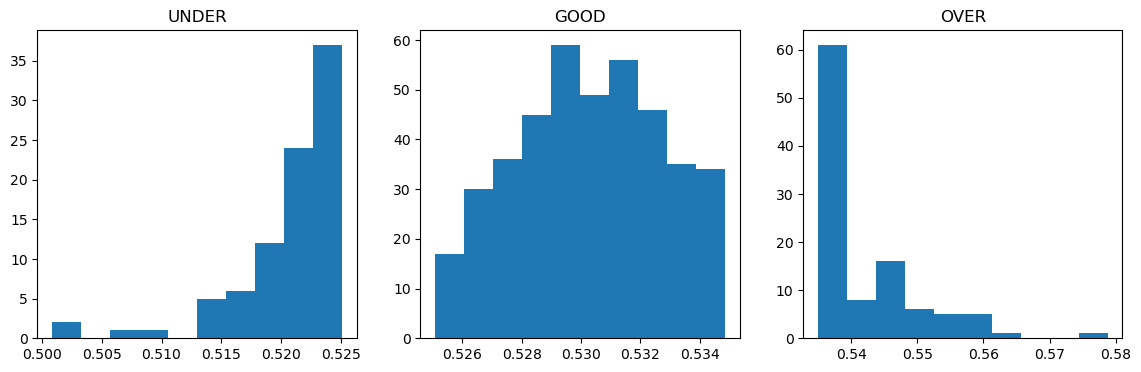

In [78]:
Q0 = train_df.loc[(train_df.Y_Class == 0)]
Q1 = train_df.loc[(train_df.Y_Class == 1)]
Q2 = train_df.loc[(train_df.Y_Class == 2)]
UNDER = pd.DataFrame(Q0.Y_Quality)
GOOD = pd.DataFrame(Q1.Y_Quality)
OVER = pd.DataFrame(Q2.Y_Quality)

Qn = [UNDER, GOOD, OVER]
tit = ["UNDER", "GOOD", "OVER"]
plt.figure(figsize=(14, 4))
for i, Q_n in enumerate(Qn):
    num = 131 + i
    plt.subplot(num)
    plt.hist(Q_n)
    plt.title(tit[i])
plt.subplots_adjust(hspace=0.3)
plt.show()

In [89]:
a = UNDER.Y_Quality.min()
b = UNDER.Y_Quality.max()
c = GOOD.Y_Quality.min()
d = GOOD.Y_Quality.max()
e = OVER.Y_Quality.min()
f = OVER.Y_Quality.max()
print("UNDER min : {}\nUNDER max : {}\n\nGOOD min : {}\nGOOD max : {}\n\nOVER min : {}\nOVER max : {}".format(a, b, c, d, e, f))

UNDER min : 0.500855556
UNDER max : 0.525066667

GOOD min : 0.525085714
GOOD max : 0.534842857

OVER min : 0.534950794
OVER max : 0.57884127


In [ ]:
train_df.insert(3, "Y_Quality_2", train_df.Y_Quality)

In [107]:
train_df.Y_Quality_2 = str(train_df.Y_Quality_2)

In [109]:
train_df["Y_Quality_2"] = train_df.loc[0.500855556 <= train_df["Y_Quality_2"] <= 0.525066667] = "UNDER"
train_df["Y_Quality_2"] = train_df.loc[0.525085714 <= train_df["Y_Quality_2"] <= 0.534842857] = "GOOD"
train_df["Y_Quality_2"] = train_df.loc[0.534950794 <= train_df["Y_Quality_2"] <= 0.57884127] = "OVER"
train_df.head()

TypeError: '>=' not supported between instances of 'str' and 'float'

In [7]:
# TIMESTAMP
train_df.TIMESTAMP = train_df.TIMESTAMP.apply(
    lambda x : pd.to_datetime(
        str(x),
        format='%Y-%m-%d %H:%M:%S'
    )
)

# PRODUCT_CODE
train_df.PRODUCT_CODE = train_df.PRODUCT_CODE.str.split('_').str[0]

In [8]:
train_df.head(10)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 05:14:00,T050304,A,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0
1,TRAIN_001,2,0.541819,2022-06-13 05:22:00,T050307,A,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
2,TRAIN_002,1,0.531267,2022-06-13 05:30:00,T050304,A,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,0.0,0.0,0.0,0.0,0.0
3,TRAIN_003,2,0.537325,2022-06-13 05:39:00,T050307,A,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
4,TRAIN_004,1,0.531590,2022-06-13 05:47:00,T050304,A,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,0.0,0.0,0.0,0.0,0.0
5,TRAIN_005,2,0.537833,2022-06-13 05:55:00,T050307,A,0.0,0.0,0.0,0.0,...,38.16,51.25,56.01,37.41,71.37,0.0,0.0,0.0,0.0,0.0
6,TRAIN_006,1,0.533665,2022-06-13 06:03:00,T050304,A,0.0,0.0,0.0,0.0,...,32.50,41.42,38.36,30.83,76.93,0.0,0.0,0.0,0.0,0.0
7,TRAIN_007,2,0.540003,2022-06-13 06:11:00,T050307,A,0.0,0.0,0.0,0.0,...,39.00,35.95,59.51,30.49,72.77,0.0,0.0,0.0,0.0,0.0
8,TRAIN_008,1,0.531821,2022-06-13 06:19:00,T050304,A,0.0,0.0,0.0,0.0,...,42.25,43.17,55.60,33.26,78.50,0.0,0.0,0.0,0.0,0.0
9,TRAIN_009,2,0.538049,2022-06-13 06:28:00,T050307,A,0.0,0.0,0.0,0.0,...,34.40,35.88,50.36,38.45,71.42,0.0,0.0,0.0,0.0,0.0


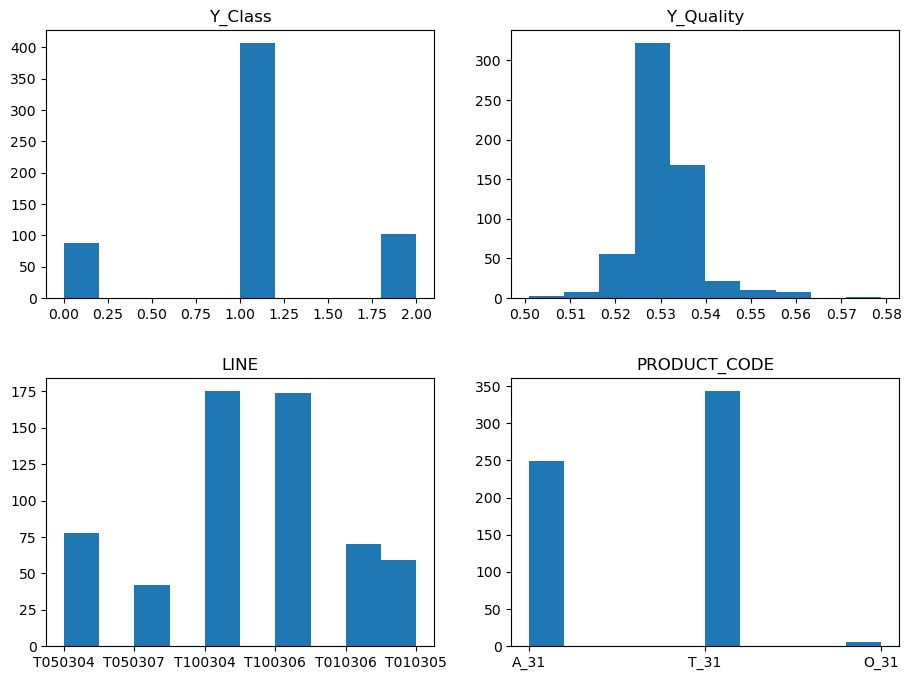

In [69]:
cols = ["Y_Class", "Y_Quality", "LINE", "PRODUCT_CODE"]
plt.figure(figsize=(11, 8))
for i in range(len(cols)):
    num = 221 + i
    plt.subplot(num)
    plt.hist(train_df[cols[i]])
    plt.title(cols[i])
plt.subplots_adjust(hspace=0.3)
plt.show()

- `Y_Class` : 클래스 불균형
- `Y_Quality` : 0.525 ~ 0.54 에 가장 많이 분포되어 있음
- `LINE` : 공정 'T100304', 'T100306'가 가장 많음
- `PRODUCT_CODE` : 제품 'O'가 가장 적음

In [11]:
L = train_df.LINE.unique()
P = train_df.PRODUCT_CODE.unique()
print("LINE : {0}\nPRODUCT_CODE : {1}".format(L, P))

LINE : ['T050304' 'T050307' 'T100304' 'T100306' 'T010306' 'T010305']
PRODUCT_CODE : ['A' 'T' 'O']


In [13]:
lines = ['T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305']
print("-- A --")
for i in lines:
    print(train_df.loc[(train_df.LINE == i) & (train_df.PRODUCT_CODE == "A")].shape[0])
print("\n-- T --")
for i in lines:
    print(train_df.loc[(train_df.LINE == i) & (train_df.PRODUCT_CODE == "T")].shape[0])
print("\n-- O --")
for i in lines:
    print(train_df.loc[(train_df.LINE == i) & (train_df.PRODUCT_CODE == "O")].shape[0])

-- A --
78
42
0
0
70
59

-- T --
0
0
172
171
0
0

-- O --
0
0
3
3
0
0


In [17]:
ts_df = train_df.set_index(["TIMESTAMP"])

In [ ]:
cols = ["Y_Class", "Y_Quality", "LINE", "PRODUCT_CODE"]
plt.figure(figsize=(15, 15))
for i in range(len(cols)):
    num = 411 + i
    plt.subplot(num)
    plt.plot(train_df[cols[i]])
    plt.xticks(rotation=25)
    plt.title(cols[i])
plt.subplots_adjust(hspace=0.45)
plt.show()

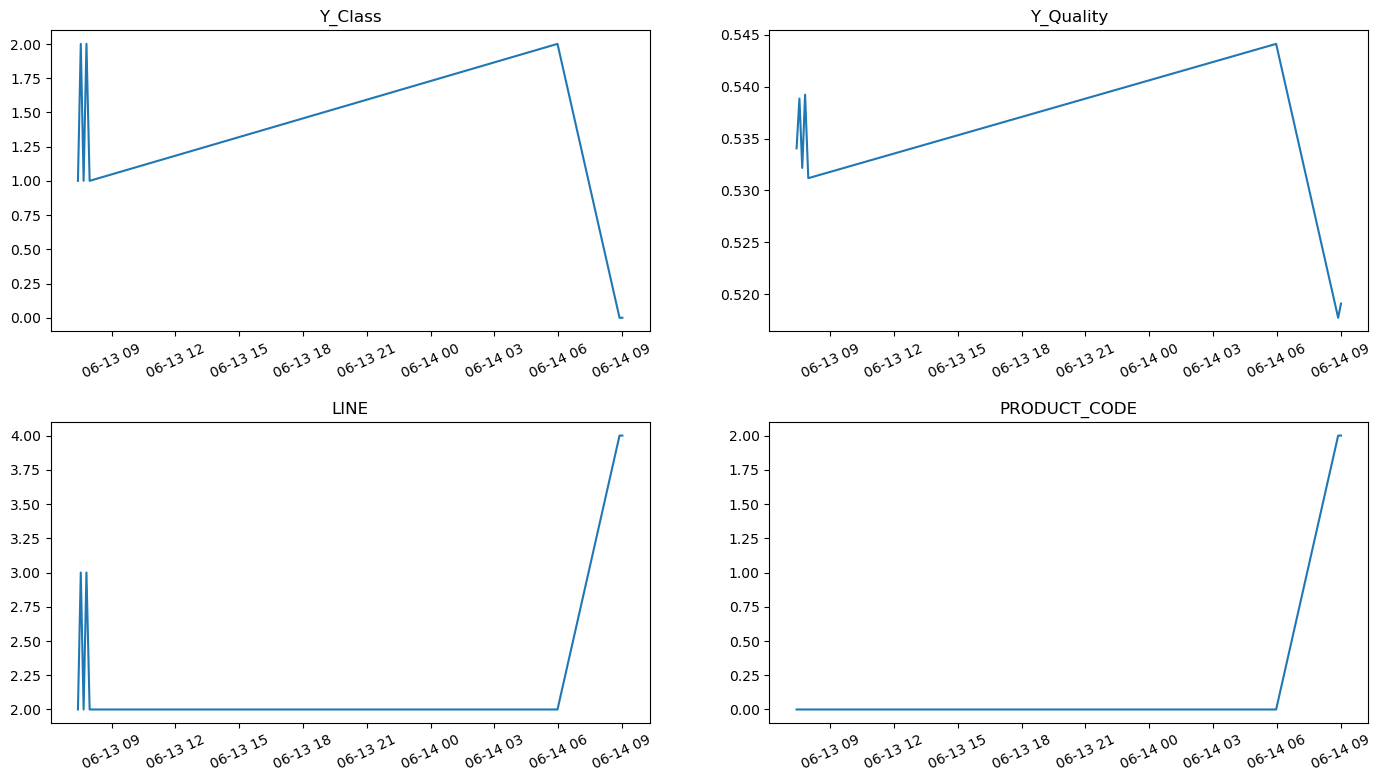

In [32]:
plt.figure(figsize=(17, 9))
for i in range(len(cols)):
    num = 221 + i
    plt.subplot(num)
    plt.plot(train_df[cols[i]][16:24])
    plt.xticks(rotation=25)
    plt.title(cols[i])
plt.subplots_adjust(hspace=0.3)
plt.show()

In [33]:
train_df[16:24]

,PRODUCT_ID,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2022-06-13 07:25:00,TRAIN_016,1,0.534054,2,0,0.0,0.0,0.0,0.0,0.0,...,40.53,31.70,49.49,35.73,79.75,0.0,0.0,0.0,0.0,0.0
2022-06-13 07:33:00,TRAIN_017,2,0.538854,3,0,0.0,0.0,0.0,0.0,0.0,...,33.16,33.26,55.97,35.17,71.40,0.0,0.0,0.0,0.0,0.0
2022-06-13 07:41:00,TRAIN_018,1,0.532170,2,0,0.0,0.0,0.0,0.0,0.0,...,35.07,48.38,36.24,33.00,75.82,0.0,0.0,0.0,0.0,0.0
2022-06-13 07:49:00,TRAIN_019,2,0.539235,3,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2022-06-13 07:58:00,TRAIN_020,1,0.531179,2,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2022-06-14 05:58:00,TRAIN_021,2,0.544129,2,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,0.0
2022-06-14 08:53:00,TRAIN_022,0,0.517719,4,2,2.0,102.0,0.0,45.0,11.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2022-06-14 09:01:00,TRAIN_023,0,0.519090,4,2,2.0,102.0,0.0,45.0,11.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0


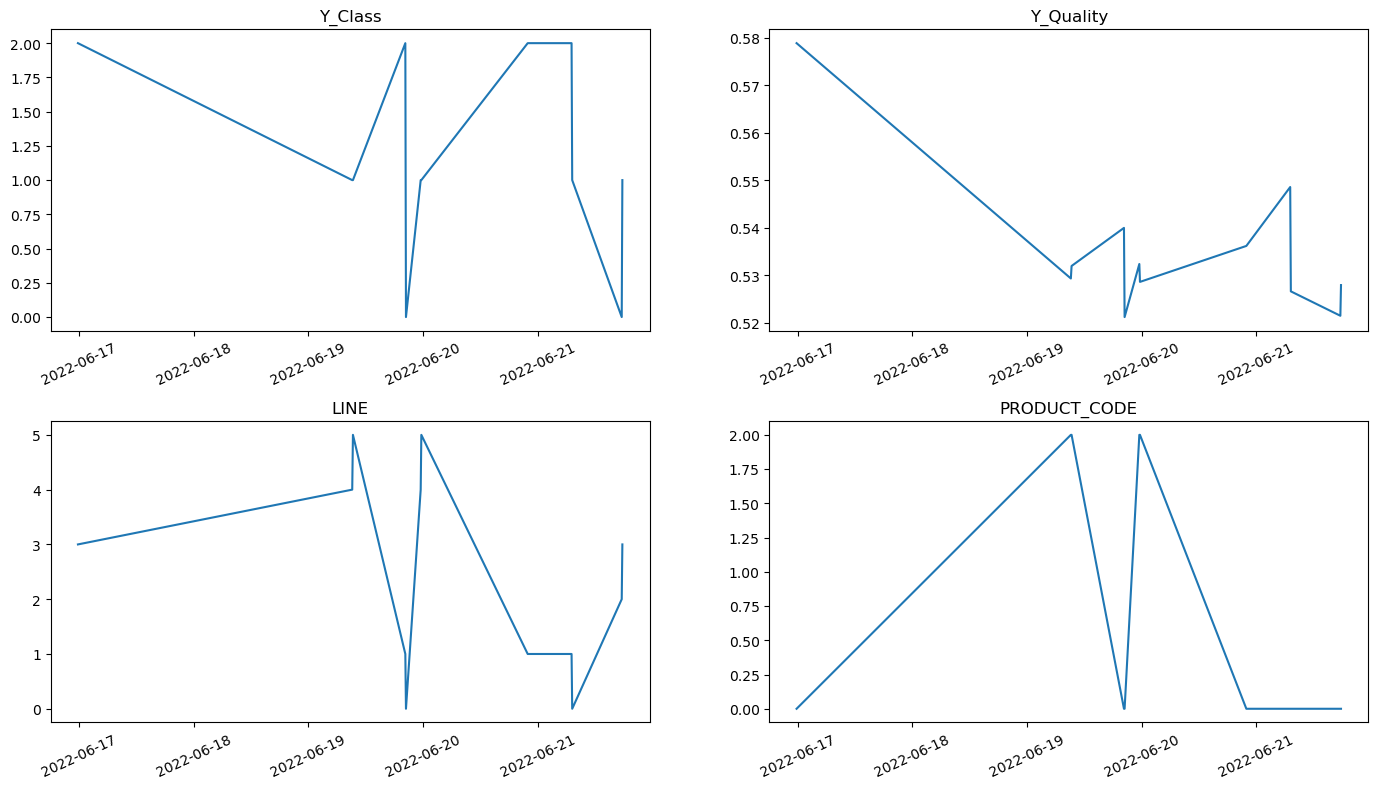

In [34]:
plt.figure(figsize=(17, 9))
for i in range(len(cols)):
    num = 221 + i
    plt.subplot(num)
    plt.plot(train_df[cols[i]][24:36])
    plt.xticks(rotation=25)
    plt.title(cols[i])
plt.subplots_adjust(hspace=0.3)
plt.show()

## Classification Model Fit

In [35]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

In [36]:
test_df = test_df.set_index(['"TIMESTAMP"'])
test_x = test_df.drop(columns=['PRODUCT_ID'])
test_x = test_x.fillna(0)
for i in qual_col:
    le = LabelEncoder()
    le = le.fit(test_x[i])
    test_x[i] = le.transform(test_x[i])
print('Done.')

Done.


In [37]:
RF = RandomForestClassifier(random_state=37).fit(train_x, train_y)
print('Done.')

Done.


## Inference

In [38]:
preds = RF.predict(test_x)
print('Done.')

Done.


## Submit

In [39]:
submit = pd.read_csv('C:\\VSC\\LGAimers_Hackathon\\dataset\\sample_submission.csv')

In [40]:
submit['Y_Class'] = preds

In [41]:
submit.to_csv('C:\\VSC\\LGAimers_Hackathon\\baseline_submission.csv', index=False)